# Baseline for the CryptoBERT model

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
import os
import pandas as pd
import numpy as np
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

ABSOLUTE_PATH = "/content/drive/My Drive/Colab Notebooks"
MODEL_NAME="ElKulako/cryptobert"
NUM_LABELS=3

## Load the preprocessed data

In [39]:
test_set_path = os.path.join(ABSOLUTE_PATH, "data/processed_coindesk_test.csv")
train_set_path = os.path.join(ABSOLUTE_PATH, "data/processed_coindesk_train.csv")
val_set_path = os.path.join(ABSOLUTE_PATH, "data/processed_coindesk_val.csv")

train_df = pd.read_csv(train_set_path)
val_df = pd.read_csv(val_set_path)
test_df = pd.read_csv(test_set_path)

print(f"Train set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")

print("\nLabel distribution in training set:")
print(train_df['label'].value_counts())
print(train_df['label'].value_counts(normalize=True))

Train set: 11956 samples
Validation set: 1495 samples
Test set: 1495 samples

Label distribution in training set:
label
2    6161
1    3119
0    2676
Name: count, dtype: int64
label
2    0.515306
1    0.260873
0    0.223821
Name: proportion, dtype: float64


 ## Load the model and tokenizer

To get the baseline results, I have used the base model without any fine-tuning, and only adapted the classification head for the sentiment task using 3 classes.

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=NUM_LABELS)
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

## Inference on base model

In [41]:
def predict_sentiment(texts, model, tokenizer, batch_size=16):
    model.eval()
    predictions = []

    # Process data in batches
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size].tolist()

        # Tokenize
        encodings = tokenizer(batch_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
        input_ids = encodings["input_ids"].to(device)
        attention_mask = encodings["attention_mask"].to(device)

        # Predict
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1).cpu().numpy()
            predictions.extend(preds)

    return predictions

# Run prediction on validation set
val_preds = predict_sentiment(val_df['full_text'], model, tokenizer)

## Evaluate the baseline model

Validation Accuracy: 0.5237

Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.10      0.18       335
     Neutral       0.32      0.64      0.43       390
    Positive       0.74      0.65      0.69       770

    accuracy                           0.52      1495
   macro avg       0.62      0.46      0.43      1495
weighted avg       0.65      0.52      0.51      1495



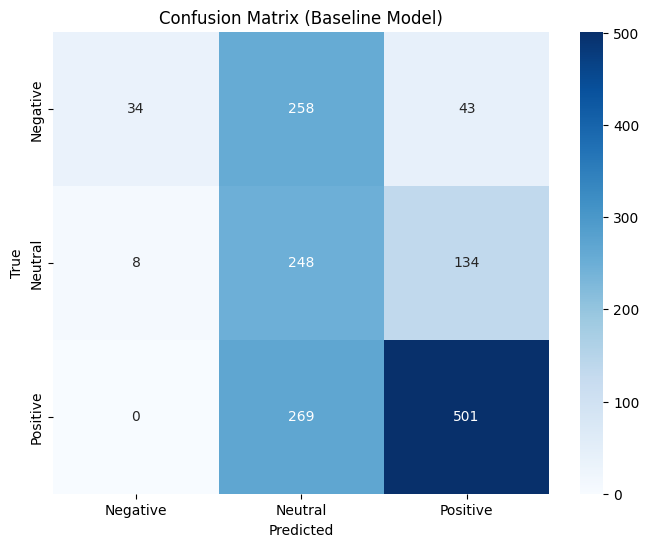

In [42]:
val_labels = val_df['label'].values
val_accuracy = accuracy_score(val_labels, val_preds)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Show classification report
print("\nClassification Report:")
target_names = ['Negative', 'Neutral', 'Positive']
print(classification_report(val_labels, val_preds, target_names=target_names))

# Create confusion matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Baseline Model)')
plt.show()

## Analyse performance on different examples

In [43]:
# Select a few examples from each class to analyse
sample_size, examples = 5, []

for label in [0, 1, 2]:
    class_df = val_df[val_df['label'] == label].sample(sample_size, random_state=42)
    sample_texts = class_df['full_text'].tolist()
    sample_labels = class_df['label'].tolist()

    # Get predictions
    sample_encodings = tokenizer(
        sample_texts, 
        truncation=True, 
        padding=True, 
        max_length=128, 
        return_tensors="pt"
    )
    input_ids = sample_encodings["input_ids"].to(device)
    attention_mask = sample_encodings["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()
        preds = np.argmax(probs, axis=-1)

    for i in range(len(sample_texts)):
        examples.append({
            'text': sample_texts[i][:100] + "...",  # Truncate for display
            'true_label': target_names[sample_labels[i]],
            'predicted_label': target_names[preds[i]],
            'confidence': probs[i][preds[i]],
            'correct': sample_labels[i] == preds[i]
        })


examples_df = pd.DataFrame(examples)
pd.set_option('display.max_colwidth', 100)
print(examples_df)

                                                                                                   text  \
0   bitcoin btc and gold report from jpmorgan! "one took the lead, here's why!". the rivalry between...   
1   market turmoil: dow jones faces significant decline amid economic concerns. coinotag news, april...   
2   april incidents reflect the multi-layered challenges binance continues to face. what do binance’...   
3   meta, amazon hit hard by trump’s tariffs as tech stocks plunge. meta and amazon are among the la...   
4   block inc. settles with new york regulators for 40m over cash app compliance violations. digital...   
5   market analysis report 21 apr 2025. slovenia proposes 25% crypto tax on sales to fiat and purcha...   
6   michelle bowman federal reserve hearing: a turning point for crypto regulation?. the post michel...   
7   trade war: tit-for-tat tariffs show limits of unilateral action, web3 leaders say. web3 experts ...   
8   bitcoin holds firm as chatter abo